In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import *
from keras.utils import np_utils
from nltk.tokenize import RegexpTokenizer
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.feature_extraction import text as sktext
from sklearn import preprocessing as skp
from keras import callbacks as kc
from keras import optimizers as ko
from keras import initializers, regularizers, constraints
from keras.engine import Layer
import keras.backend as K
from sklearn.metrics import f1_score
from keras.utils.vis_utils import model_to_dot
from keras import models
from keras import layers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, Flatten, GlobalAveragePooling1D, Reshape
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import Constant


Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
df = pd.read_csv('final_HEOT_data.csv')

In [4]:
df.head()

,Unnamed: 0,Unnamed: 0.1,label,tweet,tokens,stem,lemmas,text
0,0,0,0.0,@saud5683 @Mutayyab420 @shivang598 @Ranask35 @...,"['user', 'user', 'user', 'user', 'user', 'user...",us us us us us us us us haa jais tum bhi abh p...,user user user user user user user user haa ja...,User user user user user user user user yes li...
1,1,2,2.0,"Banti hai empowered woman, feminism pe gyan pe...","['banti', 'hai', 'empowered', 'woman', 'femini...",bant hai empow wom femin pe gyan pelt hai aur ...,banti hai empower woman feminism pe gyan pelti...,Becomes Empowered Woman Feminism thrives and w...
2,2,4,2.0,RT @kim_jong_korea: @updatingwait @Acutereply ...,"['rt', 'user', 'user', 'user', 'ab', 'usko', '...",rt us us us ab usko chhod mjse bat kr ter baap...,rt user user user ab usko chhod mjse bat kr te...,"Rat user, user, user, leave him now, which thi..."
3,3,6,2.0,@InviSibleSold @mabkhan86 @dridadahn Punjab in...,"['user', 'user', 'user', 'punjab', 'in', 'mada...",us us us punjab in madarchodon ko khil rah hai...,user user user punjab in madarchodon ko khila ...,USER USER USER PUNJAB FEATURING MADARCHODO IS ...
4,4,8,2.0,RT @MrMonsterSaid: Agar koi bole ki ja ke chil...,"['rt', 'user', 'agar', 'koi', 'bole', 'ki', 'j...",rt us ag koi bol ki ja ke chil maar to madarch...,rt user agar koi bole ki ja ke chill maar to m...,"Rat user if someone says to kill, then to kill..."


In [5]:
df['label'] = df['label'].astype(int)

In [6]:
df = df.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

In [7]:
train_df = pd.DataFrame()
train_df['content'] = df['lemmas']
train_df['class'] = df['label']

Training data phrase length distribution


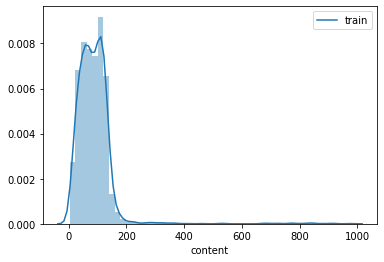

In [8]:
print("Training data phrase length distribution")
sns.distplot(train_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "train"})

In [9]:
print('Most frequent sentence length in training:')
lens = train_df['content'].map(lambda ele: len(ele))
counts = np.bincount(lens)
print(np.argmax(counts))

Most frequent sentence length in training:
55


Testing data phrase length distribution


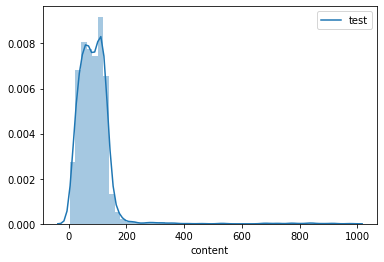

In [10]:
print("Testing data phrase length distribution")
sns.distplot(train_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "test"})

In [11]:
train_df.shape

(3189, 2)

In [12]:
import json

In [299]:
with open('density.json','r') as f:
    sents = json.load(f)

In [300]:
test_df = pd.DataFrame()
test_df['content'] = sents['0']
test_df['class'] = sents['2']
test_df['density'] = sents['1']

In [301]:
test_df = test_df[test_df['class']==2]

In [302]:
sents.keys()

dict_keys(['0', '1', '2'])

In [303]:
test_df.head()

,content,class,density
0,banti hai empower woman feminism pe gyan pelti...,2.0,1
1,rt user user user ab usko chhod mjse bat kr te...,2.0,2
2,user user user punjab in madarchodon ko khila ...,2.0,1
3,rt user agar koi bole ki ja ke chill maar to m...,2.0,5
5,user to bhosdike tere baap ka kya ja raha hai ...,2.0,1


In [232]:
test_df = train_df[2800:]
train_df = train_df[:2800]

Testing data phrase length distribution


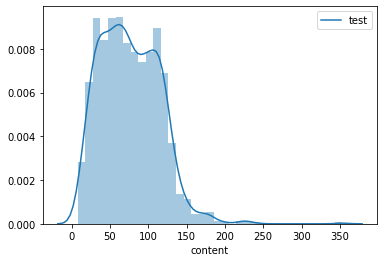

In [304]:
print("Testing data phrase length distribution")
sns.distplot(test_df['content'].map(lambda ele: len(ele)), kde_kws={"label": "test"})

In [305]:
print('Most frequent sentence length in testing:')
lens = test_df['content'].map(lambda ele: len(ele))
counts = np.bincount(lens)
print(np.argmax(counts))

Most frequent sentence length in testing:
72


In [306]:
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [307]:

## A dictionary to map the punctuations present in the text to relevant strings or symbols
punct_mapping = {"‘": "'", 
                 "₹": "e", 
                 "´": "'", 
                 "°": "", 
                 "€": "e", 
                 "™": "tm",
                 "√": " sqrt ",
                 "×": "x",
                 "²": "2",
                 "—": "-",
                 "–": "-",
                 "’": "'",
                 "_": "-",
                 "`": "'",
                 '“': '"',
                 '”': '"',
                 '“': '"',
                 "£": "e",
                 '∞': 'infinity',
                 'θ': 'theta',
                 '÷': '/',
                 'α': 'alpha',
                 '•': '.',
                 'à': 'a',
                 '−': '-',
                 'β': 'beta',
                 '∅': '',
                 '³': '3',
                 'π': 'pi',
                 ',':'',
                 '.':'',
                 ':':'',
                 '(':'',
                 ')':'',
                 '*':'',
                '"':'',
                '<':'',
                '>':''}

In [308]:
def unknown_punct(embed, punct):
    unknown = ''
    for p in punct:
        if p not in embed:
            unknown += p
            unknown += ' '
    return unknown

## Function to remove special characters from the sentences (if any present)
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  # Other special characters that I have to deal with in last
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

In [309]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: clean_special_chars(text, punct, punct_mapping))
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: clean_special_chars(text, punct, punct_mapping))

In [310]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [311]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [312]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: clean_contractions(text, contraction_mapping))
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: clean_contractions(text, contraction_mapping))

In [313]:
train_df.loc[:, 'content'] = train_df['content'].map(lambda text: text.lower())
test_df.loc[:, 'content'] = test_df['content'].map(lambda text: text.lower())

In [314]:
data = train_df.values
data_test = test_df.values

In [315]:
X_train = data[:,0]
Y_train = data[:,1]

X_test = data_test[:,0]
# Y_test = data_test[:,1]

print (X_train.shape, Y_train.shape, X_test.shape)
print ("-------------------------")
print (X_test[0])
print (X_train[0], Y_train[0])

(2800,) (2800,) (1628,)
-------------------------
banti hai empower woman feminism pe gyan pelti hai aur din bhar roti rehti hai pahle rona band kar madarchod
user user user user user user user user haa jaise tum bhi abhi pxe2x80xa6 url 0


In [316]:
tokenizer = RegexpTokenizer("[a-zA-Z]+")
lemmatizer = WordNetLemmatizer()

In [317]:
for ix in range(X_train.shape[0]):
    X_train[ix] = tokenizer.tokenize(X_train[ix])
    X_train[ix] = [lemmatizer.lemmatize(i) for i in X_train[ix]]
    
for ix in range(X_test.shape[0]):
    X_test[ix] = tokenizer.tokenize(X_test[ix])
    X_test[ix] = [lemmatizer.lemmatize(i) for i in X_test[ix]]

In [318]:

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
#     print(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
## Length of the list of unique_words gives the no of unique words
print("Vocabulary Size:")
print(len(list(unique_words)))
print("Maximum length of sentence:")
print(len_max)

100%|██████████| 2800/2800 [00:00<00:00, 707472.96it/s]

Vocabulary Size:
7656
Maximum length of sentence:
295


In [319]:
tokenizer_keras = Tokenizer(num_words=len(list(unique_words)))
tokenizer_keras.fit_on_texts(list(X_train))
X_train = tokenizer_keras.texts_to_sequences(X_train)
X_test = tokenizer_keras.texts_to_sequences(X_test)

## Padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
## Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
print(X_train.shape,X_test.shape)

(2800, 295) (1628, 295)


In [52]:
embeddings_index = dict()

In [53]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

In [54]:
model = Word2Vec.load("word2vec.model")

In [55]:
word_vectors = model.wv

In [56]:
print(data[:,0])

[list(['user', 'user', 'user', 'user', 'user', 'user', 'user', 'user', 'haa', 'jaise', 'tum', 'bhi', 'abhi', 'pxe', 'x', 'xa', 'url'])
 list(['banti', 'hai', 'empower', 'woman', 'feminism', 'pe', 'gyan', 'pelti', 'hai', 'aur', 'din', 'bhar', 'roti', 'rehti', 'hai', 'pahle', 'rona', 'band', 'kar', 'madarchod'])
 list(['rt', 'user', 'user', 'user', 'ab', 'usko', 'chhod', 'mjse', 'bat', 'kr', 'tera', 'baap', 'aa', 'gya', 'hai', 'ab', 'to', 'ldki', 'ko', 'beech', 'me', 'q', 'la', 'ra', 'hai', 'madarchod', 'txe', 'x', 'xa'])
 ... list(['bjp', 'will', 'win', 'jai', 'ram', 'modi', 'bhagwan'])
 list(['kya', 'karna', 'hai', 'ab', 'bol'])
 list(['sab', 'mar', 'jayenge', 'ba', 'main', 'zinda', 'rahunga'])]


In [57]:
embeddings_index = dict()

In [58]:
for sent in data[:,0]:
    for token in sent:
        word = token
        word = lemmatizer.lemmatize(word)
        try:
            coefs = np.asarray(word_vectors[word], dtype='float32')
#             print(coefs)
#             print(coefs.shape)
            embeddings_index[word] = coefs
        except:
            print(word)
            coefs = np.zeros((200,))
            embeddings_index[word] = coefs

pxe
txe
maxe
haixe
bhaxe
haxe
month
throwxe
chukexe
singalxe
xf
fx
xe
compaxe
madarchodbharxe
bhoktixe
madarchodxe
rallxe
chuxe
nexe
priest
xe
hxe
madarchxe
xf
fxa
chodxe
rxe
xf
fx
xf
fx
xf
fx
mentionxe
txe
yahaxe
kahixe
fuckixe
karxe
baaxe
xf
fx
cxf
fx
cxf
fx
cxf
fx
cxf
fx
cxf
fx
cxf
fx
cxf
fx
cxf
fx
mentionxe
sexe
dxe
haixe
xf
fx
cxf
fx
cxf
fx
cxf
fx
cxf
fx
hxe
motherfucker
urxe
bhotxf
fx
xf
fx
xf
fx
xf
fx
xf
fx
kxe
bahenchodxf
fx
daxe
bhaxe
baxe
xf
fx
xf
fx
fikxe
goon
statistic
startup
pataxe
haixf
fx
xf
fx
xf
fx
xf
fx
haixf
fx
xf
fx
saxe
nahixe
kuttaxe
fromxe
haixe
sakxe
haixf
fx
xf
fx
xf
fx
xf
fx
haixf
fx
xf
fx
katvexe
kixe
kadvaxe
hexe
bxe
shxe
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
axa
xf
fx
axa
pxe
thexe
woxe
mentionxe
merxe
nahinnrepxe
musalmanoxe
mentionxe
kabhixe
parwahxe
virodhxe
pataxe
kaxf
fx
xf
fx
chuxe
xf
fx
timexf
fx
mentionxe
mentionxe
haxe
mentionxe
naxe
mentionxe
abxe
merxe
mentionxe
chodraxe
tabxe
kixe
terxe
kexe
redxe
laxe
mentionxe
nupxe
mentionxe
choxe
daaxe
xe
bac

xe
dxb
xecxa
fx
xecxb
axb
xebxa
xebxa
cxebx
dxbcxebx
dxbcxebx
fx
xebxb
ax
xeaxb
bx
xf
fx
xf
fx
yexe
xeaxb
axb
xebxb
cx
cxbcxebxa
xeaxb
xacxebxa
xebxa
execx
dxb
bx
cxebx
bxa
xecxa
xbcxebxacxb
fx
xebxaaxa
cxeaxb
xebxa
cxecx
dxb
ax
xecxa
cxebxb
cx
xecxa
xe
xe
xe
xe
xe
xe
xe
dxb
xebxb
xebxb
xecxb
bxb
exa
xacxebx
fx
xebxa
cxecx
bx
fx
bx
bxa
xebxb
xebxa
bx
fx
xebxb
xebxa
xebxb
xeaxb
xebxa
xbcxebx
fx
xecxa
axa
xe
xe
xe
xe
xe
xe
xeaxb
xebxa
xbcxecxa
xecxa
xecxa
xecxb
dxeaxb
fx
xebxaaxa
xebxa
bxa
xeaxb
ax
xeaxb
axa
dxbcxecx
dxb
cx
dxb
xecxa
xebxaaxa
xebxa
bx
cxebx
ax
xebxb
dxb
xebxa
execx
dx
xeaxb
xeaxb
bxa
nxeaxb
axa
dxbcxecx
dxb
cx
dxb
xebxacxb
dxb
xebxa
xeaxb
dxb
fxb
fx
dx
xecxa
xebxa
dxb
xeaxb
bx
xeaxb
cxedx
dxb
xebxa
xeaxb
xeaxb
cxebxacxb
xeaxb
fxb
xeaxb
bx
dxecx
dx
xeaxb
xebxa
cx
xebxb
dx
xebxaaxb
xeaxb
xeaxb
bx
dxecx
cxbcxebxa
cx
xebxb
dxb
xecxa
cxebx
cx
xebxa
dxeaxb
dx
xeaxb
cxe
xebxb
xeaxb
axb
xacxebx
fxacxebxb
cx
dxb
xecxa
xebxa
bx
cxeaxb
bx
bxa
bxa
dxbc
xecxb
axb
xebxb
bxa
xebxa
bx
c

xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
mentionxe
mentionxe
xe
krdunganbhasxe
mentionxe
twicexe
xf
fx
xf
fx
xf
fx
mentionxe
krdungaxe
governmxe
mentionxe
xe
xe
xe
xe
xe
xe
xe
xaexe
xe
xe
dxe
xe
bxe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xe
xbaxefxb
fxe
xbaxefxb
fxf
fx
cxf
fx
fxe
conxe
xf
fx
xf
fx
watchman
jyaxe
meixf
fx
koxf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
xf
fx
insaxe
ghatxe
kaxe
maxe
shamsxe
soxe
sayxe
mxe
haxe
amxe
donxe
haixe
toxe
exe
musxe
xf
fx
ann
xf
fx
ann
hukumatxe
haixe
dxa
xefxb
fninshallah
chahixe
mandirmasjidhinduxe
xe
hukumatxe
rahixe
kajxe
hainmusalxe
mandirxe
disxe
mentionxe
xf
fx
xf
fx
hxe
tohxe
hainxe
xf
fx
xacxf
fxa
hooxe
pahxe
rahxe
haixe
dxa
xefxb
fninshallah
logonxe
radical
mentionxe
mentionxe
willxe
xe
extremist
indxe
sxe
stonexe
xe
fadxe
text
ofxe
mentionxe
mentionxe
asxe
chiexe
arexe
mentionxe
apxe
xaaxe
dxe
xe
cxe
xe
xe
xaaxe
xbexe
xe
dxe
fxe
xe
xaaxe
xbfxe
xe
xbexe
xafxe
xbfxe
xe
xaaxe
xe
xe
xa

In [59]:
len(embeddings_index)

7654

In [60]:
vocab_size=len(list(unique_words))
embedding_matrix = np.zeros((vocab_size+1, 200))
for word, i in tokenizer_keras.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [61]:
embed_size = 200
max_features = vocab_size + 1 

In [62]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [63]:
text_input_layer = Input(shape=(len_max,), dtype='int32')
doc_embedding   = Embedding(len(list(unique_words))+1,
                            200,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=len_max,
                            trainable=False)(text_input_layer)

convs = []
filter_sizes = [4, 5]
# filter_sizes = [5]

l_conv = Conv1D(filters=128, kernel_size=[3], padding='valid', activation='relu')(doc_embedding)

for filter_size in filter_sizes:
    l_conv = Conv1D(filters=128, kernel_size=filter_size, padding='valid', activation='relu')(l_conv)
    convs.append(l_conv)
cnn_feature_maps = convs

reg_drop = Dropout(0.3)(l_conv)
# flat = Flatten()(reg_drop)
sentence_encoder1 = Bidirectional(LSTM(128,return_sequences=True))(reg_drop)
sentence_encoder2 = Bidirectional(LSTM(128,return_sequences=True))(sentence_encoder1)
att = Attention(286)(sentence_encoder2)
fc_layer =Dense(128, activation="relu")(att)
output_layer = Dense(3,activation="softmax")(fc_layer)

model_1 = Model(inputs=[text_input_layer], outputs=[output_layer])

W0910 17:14:22.352337 139834873210688 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0910 17:14:22.367113 139834873210688 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0910 17:14:22.396717 139834873210688 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0910 17:14:22.429100 139834873210688 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is depre

In [47]:
checkpoint=ModelCheckpoint('model_self_embedding_final.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

In [48]:
X_full = np.concatenate((X_train, X_test))
Y_full = np.concatenate((Y_train, Y_test))

NameError: name 'Y_test' is not defined

In [49]:
Y_full = np_utils.to_categorical(Y_full)

NameError: name 'Y_full' is not defined

In [50]:
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(X_full, Y_full, random_state=3, test_size=0.2)

NameError: name 'Y_full' is not defined

In [64]:
model_1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_1.summary()

W0910 17:14:27.918540 139834873210688 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0910 17:14:27.923562 139834873210688 deprecation_wrapper.py:119] From /home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 295)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 295, 200)          1531400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 293, 128)          76928     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 290, 128)          65664     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 286, 128)          82048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 286, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 286, 256)          2631

In [149]:
model_1.load_weights('weights_base_[C-LSTM].best.hdf5')

In [150]:
file_path = "weights_base_[C-LSTM].best.hdf5"
early_stopping = EarlyStopping(monitor="val_acc", mode="max", patience=10)
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=2, save_best_only=True, mode='max')

In [ ]:
hist = model_1.fit(x_train,y_train,validation_data=(x_test,y_test),
                epochs = 10, batch_size=16,shuffle=True,callbacks=[checkpoint,early_stopping])

In [202]:
X_test.shape

(115, 295)

In [ ]:
X_test[:10]

In [ ]:
model_1.summary()

In [321]:
pred_val = model_1.predict(X_test)

In [322]:
nums = [x[0] for x in pred_val]

In [323]:
nums

[0.004902105,
 0.0002767692,
 0.0033687912,
 0.0006698479,
 0.0005342519,
 0.0008729696,
 0.016835764,
 0.015499741,
 0.014221174,
 0.0037725803,
 0.006123047,
 0.002251305,
 0.0057216045,
 0.0064413087,
 0.115851715,
 0.0128274225,
 0.33165053,
 0.0010191129,
 0.021590767,
 0.0023416025,
 0.00082335935,
 0.008844466,
 0.204935,
 0.00045920932,
 0.032438222,
 0.00096986076,
 0.1456474,
 0.042850394,
 0.3431903,
 0.0022640221,
 0.00051126454,
 0.034949884,
 0.02441098,
 0.0002927832,
 0.0018094069,
 0.006254654,
 0.005580847,
 0.00031700684,
 0.0008387239,
 0.002481056,
 0.0004520283,
 0.0043319366,
 0.009850471,
 0.002007707,
 0.0022435405,
 0.029002769,
 0.00045523257,
 0.2570337,
 0.025604522,
 0.0008338414,
 0.005547119,
 0.011219676,
 0.0063087074,
 0.0030531033,
 0.012805893,
 0.01919711,
 0.01497778,
 0.003455908,
 0.00046959022,
 0.02582841,
 0.8841531,
 0.008343301,
 0.0013858076,
 0.0053390553,
 0.0011023415,
 0.0034641752,
 0.012178758,
 0.0014472333,
 0.00840555,
 0.00922444

In [324]:
nums = [1 - a for a in nums]

In [325]:
nums

[0.9950978951528668,
 0.9997232308087405,
 0.99663120880723,
 0.9993301521171816,
 0.9994657480856404,
 0.9991270303726196,
 0.9831642359495163,
 0.9845002591609955,
 0.9857788262888789,
 0.9962274197023362,
 0.9938769531436265,
 0.9977486950810999,
 0.9942783955484629,
 0.9935586913488805,
 0.8841482847929001,
 0.9871725775301456,
 0.6683494746685028,
 0.9989808871177956,
 0.9784092325717211,
 0.9976583975367248,
 0.9991766406456009,
 0.9911555340513587,
 0.7950650006532669,
 0.9995407906826586,
 0.9675617776811123,
 0.9990301392390393,
 0.854352593421936,
 0.9571496061980724,
 0.6568096876144409,
 0.9977359778713435,
 0.9994887354550883,
 0.9650501161813736,
 0.975589020177722,
 0.9997072168043815,
 0.9981905930908397,
 0.9937453460879624,
 0.9944191528484225,
 0.9996829931624234,
 0.9991612760932185,
 0.9975189440883696,
 0.9995479717035778,
 0.9956680634059012,
 0.9901495287194848,
 0.9979922929778695,
 0.9977564595174044,
 0.9709972310811281,
 0.9995447674300522,
 0.74296629428863

In [326]:
np.save('dist2.npy',nums)

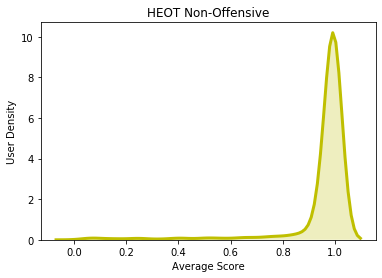

In [330]:
# plt.ylim(0.0, 3.0)
# plt.xlim(0.0,1.0)
plt.xlabel("Average Score")
plt.ylabel("User Density")
plt.title('HEOT Non-Offensive')
sns.distplot(nums, hist = False, kde = True, bins = list1,
                 kde_kws = {'shade': True, 'linewidth': 3}, color='y')

In [328]:
test_df.head()

,content,class,density
0,banti hai empower woman feminism pe gyan pelti...,2.0,1
1,rt user user user ab usko chhod mjse bat kr te...,2.0,2
2,user user user punjab in madarchodon ko khila ...,2.0,1
3,rt user agar koi bole ki ja ke chill maar to m...,2.0,5
5,user to bhosdike tere baap ka kya ja raha hai ...,2.0,1


In [198]:
density = test_df['density']

In [199]:
len(nums), len(density)

(1628, 1628)

In [200]:
bins = np.unique(density)

In [201]:
bin_conf = {}
for score, den in zip(nums,density):
    if den in bin_conf:
        bin_conf[den].append(score)
    else:
        bin_conf[den] = [score]

In [202]:
bin_avg = {}
for cur in bin_conf:
    bin_avg[cur] = np.average(bin_conf[cur])

In [162]:
bin_avg[0] = 0.03

In [203]:
bin_avg

{1: 0.9320678779060604,
 2: 0.9471493650340966,
 5: 0.9536922541312853,
 3: 0.9635817749190796,
 6: 0.9852346417249646,
 4: 0.989462390592962,
 7: 0.9941118840581892,
 8: 0.9964850645521534,
 9: 0.9965580107760615,
 10: 0.9774563974303115,
 13: 0.9524952173233032,
 11: 0.998973710637074,
 12: 0.9979803098831326}

In [210]:
bins = []
vals = []
for key, val in bin_avg.items():
    bins.append(key)
    vals.append(val)
    print(key, val)

1 0.9320678779060604
2 0.9471493650340966
5 0.9536922541312853
3 0.9635817749190796
6 0.9852346417249646
4 0.989462390592962
7 0.9941118840581892
8 0.9964850645521534
9 0.9965580107760615
10 0.9774563974303115
13 0.9524952173233032
11 0.998973710637074
12 0.9979803098831326


In [211]:
list1, list2 = zip(*sorted(zip(bins, vals)))

In [112]:
import seaborn as sns

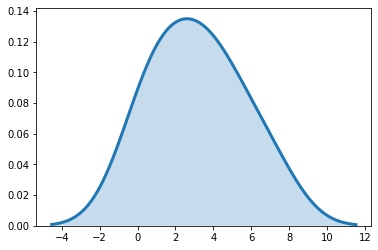

In [113]:
sns.distplot(list1, hist = False, kde = True, bins = list1,
                 kde_kws = {'shade': True, 'linewidth': 3}, )

In [166]:
list2, list1

((0.03,
  0.6858121423680131,
  0.7430294559782614,
  0.866389047862245,
  0.8081196892773732,
  0.8041830454021692,
  0.7332006941239039,
  0.8673814720241353,
  0.9994916255236603),
 (0, 1, 2, 3, 4, 5, 6, 7, 12))

In [223]:
# list1 = [0,1,2,3,4,5,6,7,12]

list3 = [1,1,1,1,1,1,1,1,1]
list4 = [0.63, 0.68, 0.74, 0.86, 0.80, 0.80, 0.73, 0.86, 0.99]
list5 = [0,1,2,3,4,5,6,7,12]
list6 = [0.03, 0.20, 0.37, 0.23, 0.45, 0.49]
list7 = [0,1,3,4,5,7]

Text(0.5, 1.0, 'HEOT Abusive')

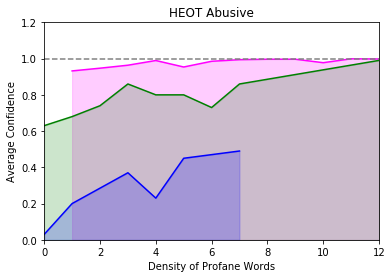

In [226]:
plt.ylim(0.0, 1.2)
plt.xlim(0,12)
plt.plot(list1, list2,color='magenta' )
plt.plot(list5, list4,color='green' )
plt.plot(list7, list6,color='blue' )
plt.plot(list5, list3, linestyle='--', color='gray')
plt.fill_between(list1, list2, alpha=0.2, color = 'magenta')
plt.fill_between(list5, list4, alpha=0.2, color = 'green')
plt.fill_between(list7, list6, alpha=0.2, color = 'blue')
plt.xlabel("Density of Profane Words")
plt.ylabel("Average Confidence")
plt.title('HEOT Abusive')

# plt.plot(list1, list2)
# plt.fill_between(list1, list2)

In [335]:
from scipy.interpolate import spline

xnew = np.linspace(0,15,300) #300 represents number of points to make between T.min and T.max

power_smooth = spline(list1,list2,xnew)

plt.plot(xnew,power_smooth)
plt.show()

ImportError: cannot import name 'spline' from 'scipy.interpolate' (/home/shivang/.conda/envs/tf_gpu/lib/python3.7/site-packages/scipy/interpolate/__init__.py)

<BarContainer object of 14 artists>

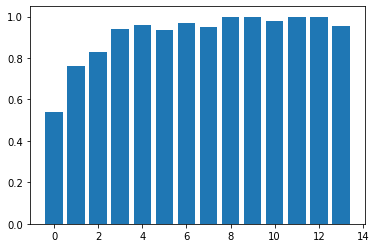

In [316]:
plt.bar(list1, list2)

In [271]:
np.average(nums)

0.845667637408412

In [209]:
np.std(nums)

0.20900899060288036

In [ ]:
pred_val = pred_val.argmax(axis=1)

In [ ]:
true = y_test.argmax(axis=1)

In [ ]:
final = pd.DataFrame()
final['true'] = true.astype(int)
final['pred'] = pred_val.astype(int)

In [ ]:
f1_score(final['true'],final['pred'], average=None)

In [ ]:
print(classification_report(final['true'], final['pred']))

In [ ]:
output1 = model_1.layers[-2].output
# dense2 = Dense(300, activation='relu', name='layer_2')(output1)
input4 = Input(shape=(209,))
dense3 = Dense(50, activation='relu', name='layer_3')(input4)
merged = concatenate([output1, dense3])
pre_final = Dense(50, activation='relu', name='pre_final')(merged)
output = layers.Dense(3, activation="softmax", name="softmax_layer0")(pre_final)

In [ ]:
model_fin = Model(inputs = [model_1.input, input4], outputs = [output])

In [ ]:
abuse_full = np.load('Abuse_Features_HEOT.npy')

In [ ]:
model_fin.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model_fin.summary()

In [ ]:
abuse_train, abuse_test, y_train, y_test = model_selection.train_test_split(abuse_full, Y_full, random_state=3, test_size=0.2)

In [ ]:
hist = model_fin.fit([x_train,abuse_train],y_train,validation_data=([x_test,abuse_test],y_test),
                epochs = 10, batch_size=16,shuffle=True,callbacks=[checkpoint,early_stopping])

In [ ]:
pred_val = model_fin.predict([x_test, abuse_test])

In [ ]:
pred_val = pred_val.argmax(axis=1)

In [ ]:
true = y_test.argmax(axis=1)

In [ ]:
final = pd.DataFrame()
final['true'] = true.astype(int)
final['pred'] = pred_val.astype(int)

In [ ]:
f1_score(final['true'],final['pred'], average=None)

In [ ]:
print(classification_report(final['true'], final['pred']))

In [ ]:
model_emb_com = Model(inputs=model_fin.inputs, outputs=[model_fin.layers[-2].output])

In [ ]:
embs = model_emb_com.predict([X_full,abuse_full])

In [ ]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)
new_values = tsne_model.fit_transform(embs)

In [ ]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

In [ ]:
labels = df['label']
colors = ['red','green', 'blue']

In [ ]:
plt.figure(figsize=(8, 8)) 
plt.scatter(x, y, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

In [ ]:
x_check = [
    'tum hindu aurat ho',
    'tum sikh aurat ho',
    'tum muslim aurat ho',
    'tum hindu aadmi ho',
    'tum sikh aadmi ho',
    'tum muslim aadmi ho',
    'tum hindu hidje ho',
    'tum muslim hidje ho',
    'tum hindu chutiye hidje ho',
    'tum sikh chutiye aadmi ho',
    'tum muslim chutiye hidje ho',
    'jo bahadur the vo balidaan ho gaye jo kayar the vo musalmaan ho gaye',
    'aaj humare hi mulk mein humko sirf isliye nishana banaya ja raha hai ki hum musalmaan hain',
    'porkistan ka rape start hone wala hai dekh ache se maa k loude hijde',
    'abe chutya bhool gaya kya kuwait war main muslim iraqi soldiers ne hi muslim kuwaiti aurat ka ladki logo ka rape Kiya tha',
    'muslim refugees are seeking refuge in christian countries ask yourself why are not they seeking refuge in muslim countries',
    'musalmaan per hasne se pahle soch jara aaj vo poori duniya ka hero hai',
    'communal criminal modi musalmaan ka khelaaf zahar ugal raha hai',
    'sahi hai in mullo ki desbhakto se phatti hai khud to jihadi hote hain inka dil to pakistan me rehta hai',
    'mujhe to comments dekh k ye lag raha hai ki musalman ka khoon khoon hai aur hindu ka khoon lizol'
]

In [ ]:
for ix in range(len(x_check)):
    x_check[ix] = tokenizer.tokenize(x_check[ix])
    x_check[ix] = [lemmatizer.lemmatize(i) for i in x_check[ix]]
    
x_check = tokenizer_keras.texts_to_sequences(x_check)
x_check = sequence.pad_sequences(x_check, maxlen=len_max)

In [ ]:
abuse = np.zeros((len(x_check),209))
abuse[0, 20:22] = 1
abuse[1,35] = 1
test = model_fin.predict([x_check, abuse])

In [ ]:
test